This notebook is divided into four sections, each of which is able to be run standalone, without running the other sections. The exception is the final sections "Adversarial Images via Gradient Ascent". This section requires trained models to be in the MODELS directory. You should have been provided some trained models in a zip, which you can upload to the directory via the files tab on the left if in Google Colab.

Special Instructions for the DenseNet section: You must upload the densenet169.pt file to the models folder.

In [1]:
import os

In [ ]:
''' Optional, use GDrive to store the dataset and models. Need to change
    the ROOT directory to point somewhere in your drive for this to work.

from google.colab import drive
drive.mount('/content/drive')
'''

" Optional, use GDrive to store the dataset and models. Need to change\n    the ROOT directory to point somewhere in your drive for this to work.\n\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [2]:
ROOT = os.path.join("content", "gradient_ascent_project", "data")
DATASET = os.path.join(ROOT, "dataset", "cifar-10-batches-py")
MODELS = os.path.join(ROOT, "models")
os.makedirs(DATASET)
os.makedirs(MODELS)

[Convolutional Network (Baseline CNN)](#convolutional)

- [Hyperparameters](#convnet-hyperparams)

[Dense Network (DenseNet)](#dense)

[Residual Network (ResNet50)](#residual)

- [Hyperparameters](#resnet-hyperparams)

[Adversarial Images via Gradient Ascent](#adversarial)

- [Hyperparameters](#adversarial-hyperparams)

[Results and Graphics](#results)

<a name="convolutional"></a>
# ConvNet
The model architecture is taken from this link: https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c

The model in the source is written in Tensorflow. We rewrite the model in Pytorch for our purposes.

In [3]:
import os
import time
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
from torch.utils.data import dataloader
from torch.utils.data.dataset import random_split
from torch import optim
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torchvision import models

from torchsummary import summary

%matplotlib inline

In [4]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
train_dataset = datasets.CIFAR10(root=DATASET, train=True, 
                                 transform=transforms.ToTensor(), 
                                 download=True)

Extracting content/gradient_ascent_project/data/dataset/cifar-10-batches-py/cifar-10-python.tar.gz to content/gradient_ascent_project/data/dataset/cifar-10-batches-py


In [6]:
means = torch.zeros(3)
stds = torch.zeros(3)

for img, _ in train_dataset:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means = means / len(train_dataset)
stds = stds / len(train_dataset)
    
print("Calculated means:", means)
print("Calculated stds:", stds)

Calculated means: tensor([0.4914, 0.4822, 0.4465])
Calculated stds: tensor([0.2023, 0.1994, 0.2010])


In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

test_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

In [8]:
train_len = int(.8 * len(train_dataset))
val_len = len(train_dataset) - train_len

train_ds = datasets.CIFAR10(root=DATASET, train=True, transform=train_transforms,
                            download=True)
train_dataset, val_dataset = random_split(train_ds,
                                          [train_len, val_len], 
                                          torch.Generator().manual_seed(0))
val_dataset.transform = test_transforms
test_dataset = datasets.CIFAR10(root=DATASET, train=False, 
                                transform=test_transforms, download=True)
print(len(train_dataset), len(val_dataset), len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
40000 10000 10000


In [9]:
""" Same architecture as 
https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c
but written for Pytorch.
"""
class ConvNet(nn.Module):

    def __init__(self, keep_prob:float=0.7):
        super().__init__()
        self.keep_prob = keep_prob

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )

        self.dense = nn.Sequential(
            nn.Linear(512 * 2 * 2, 128),
            nn.Dropout(1 - self.keep_prob),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.Dropout(1 - self.keep_prob),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.Dropout(1 - self.keep_prob),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.Dropout(1 - self.keep_prob),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 10),
        )

    def forward(self, x : Tensor) -> Tensor:
        x = self.convolutional(x)
        flat = x.view(x.shape[0], -1)
        x = self.dense(flat)
        return x

<a name="convnet-hyperparams"></a>
### ConvNet Hyperparameters

In [10]:
EPOCHS = 30
BATCH_SIZE = 256
KEEP_PROB = 0.7
LEARNING_RATE = 1e-3

In [11]:
convnet = ConvNet(keep_prob=KEEP_PROB)

In [12]:
optimizer = optim.Adam(convnet.parameters(), lr=LEARNING_RATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.CrossEntropyLoss()

convnet = convnet.to(device)

loss_fn = loss_fn.to(device)

In [13]:
summary(convnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
         MaxPool2d-2           [-1, 64, 16, 16]               0
              ReLU-3           [-1, 64, 16, 16]               0
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
              ReLU-7            [-1, 128, 8, 8]               0
       BatchNorm2d-8            [-1, 128, 8, 8]             256
            Conv2d-9            [-1, 256, 8, 8]         295,168
        MaxPool2d-10            [-1, 256, 4, 4]               0
             ReLU-11            [-1, 256, 4, 4]               0
      BatchNorm2d-12            [-1, 256, 4, 4]             512
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
        MaxPool2d-14            [-1, 51

In [14]:
train_loader = dataloader.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = dataloader.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = dataloader.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [15]:
def calculate_accuracy(y_pred:torch.Tensor, y:torch.Tensor):
    '''
        Calculate the number of correct y predictions divided by the total
        number of predictions.

        Args:
            y_pred (torch.Tensor): A (Nx2) tensor, each row contains the 
                                   prediction of the model for a horse vs.
                                   a human.
            y (torch.Tensor): A (N,) tensor containing the true classes for each
                              image.
        Returns:
            acc (float): The proportion of correct predictions over total
                         predictions.
    '''
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [16]:
def train(model, iterator, optimizer, loss_fn, device):
    '''
        Performs a single pass through the batch iterator, computes error,
        and updates model weights.

        Args:
            model (ConvNet): The CNN to perform weight updates on.
            iterator (DataLoader): Iterator that holds BATCH_SIZE img,class
                                   pairs at a time.
            optimizer (optim): Learning rate optimizer for individual parameters
            loss_fn: Computes loss and gradient descent for model parameters
            device: GPU or CPU
        Returns:
            Average loss and accuracy for all samples in batch.
    '''
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.to(device)
    loss_fn.to(device)
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
def evaluate(model, iterator, loss_fn, device):
    '''
        Performs a single pass through the batch iterator, and computes loss
        and accuracy.

        Args:
            model (ConvNet): The CNN model to make predictions.
            iterator (DataLoader): Iterator that holds BATCH_SIZE img,class
                                   pairs at a time.
            loss_fn: Computes loss for predicted values and actual values
            device: GPU or CPU
        Returns:
            Average loss and accuracy for all samples in batch.
    '''

    epoch_loss = 0
    epoch_acc = 0
    
    model.to(device)
    loss_fn.to(device)

    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def epoch_time(start_time, end_time):
    '''
        Converts a given start time and end time into a duration in min:sec
        format.
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
best_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(convnet, train_loader, optimizer, loss_fn, device)
    valid_loss, valid_acc = evaluate(convnet, val_loader, loss_fn, device)
        
    if valid_loss <= best_loss:
        best_loss = valid_loss
        print("Better loss, saving model. . .")
        torch.save(convnet.state_dict(), os.path.join(MODELS, "conv-model.pt"))

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print("Epoch:", epoch+1, "| Epoch Time:", epoch_mins, "m ", epoch_secs,"s")
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

Better loss, saving model. . .
Epoch: 1 | Epoch Time: 0 m  29 s
	Train Loss: 1.680 | Train Acc: 38.68%
	 Val. Loss: 1.512 |  Val. Acc: 45.72%
Better loss, saving model. . .
Epoch: 2 | Epoch Time: 0 m  27 s
	Train Loss: 1.372 | Train Acc: 49.99%
	 Val. Loss: 1.342 |  Val. Acc: 52.04%
Better loss, saving model. . .
Epoch: 3 | Epoch Time: 0 m  27 s
	Train Loss: 1.236 | Train Acc: 55.37%
	 Val. Loss: 1.215 |  Val. Acc: 56.69%
Better loss, saving model. . .
Epoch: 4 | Epoch Time: 0 m  26 s
	Train Loss: 1.144 | Train Acc: 59.28%
	 Val. Loss: 1.118 |  Val. Acc: 60.00%
Better loss, saving model. . .
Epoch: 5 | Epoch Time: 0 m  26 s
	Train Loss: 1.078 | Train Acc: 61.64%
	 Val. Loss: 1.033 |  Val. Acc: 63.03%
Better loss, saving model. . .
Epoch: 6 | Epoch Time: 0 m  26 s
	Train Loss: 1.020 | Train Acc: 63.81%
	 Val. Loss: 1.027 |  Val. Acc: 62.80%
Better loss, saving model. . .
Epoch: 7 | Epoch Time: 0 m  26 s
	Train Loss: 0.968 | Train Acc: 65.71%
	 Val. Loss: 0.976 |  Val. Acc: 65.70%
Better

In [20]:
convnet = ConvNet(keep_prob=KEEP_PROB)
convnet.load_state_dict(torch.load(os.path.join(MODELS, "conv-model.pt")))

val_loss, val_acc = evaluate(convnet, val_loader, loss_fn, device)
test_loss, test_acc = evaluate(convnet, test_loader, loss_fn, device)

print(f'Best Validation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%')
print(f'Testing Loss: {test_loss:.3f} | Testing Acc: {test_acc*100:.2f}%')

Best Validation Loss: 0.735 | Validation Acc: 75.16%
Testing Loss: 0.666 | Testing Acc: 77.44%


<a name="dense"></a>
# DenseNet

A completely pretrained model taken from 
https://github.com/huyvnphan/PyTorch_CIFAR10

All we do is perform evaluation on the model.

In [21]:
import os
import time
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
from torch.utils.data import dataloader
from torch.utils.data.dataset import random_split
from torch import optim
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torchvision import models

from torchsummary import summary

%matplotlib inline

In [22]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [23]:
""" From https://github.com/huyvnphan/PyTorch_CIFAR10 """
__all__ = ['DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161']

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate,
                                bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=10):

        super(DenseNet, self).__init__()

        # First convolution
        
        # CIFAR-10: kernel_size 7 ->3, stride 2->1, padding 3->1
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=3, stride=1,
                                padding=1, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))
        ## END

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress, device, **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        script_dir = os.path.dirname(__file__)
        state_dict = torch.load(script_dir + '/state_dicts/'+arch+'.pt', map_location=device)
        model.load_state_dict(state_dict)
    return model


def densenet121(pretrained=False, progress=True, device='cpu', **kwargs):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress, device,
                     **kwargs)


def densenet161(pretrained=False, progress=True, device='cpu', **kwargs):
    r"""Densenet-161 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet161', 48, (6, 12, 36, 24), 96, pretrained, progress, device,
                     **kwargs)


def densenet169(pretrained=False, progress=True, device='cpu', **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet169', 32, (6, 12, 32, 32), 64, pretrained, progress, device,
                     **kwargs)


def densenet201(pretrained=False, progress=True, device='cpu', **kwargs):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet201', 32, (6, 12, 48, 32), 64, pretrained, progress, device,
                     **kwargs)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.CrossEntropyLoss()

densenet = densenet169(pretrained=False, progress=False, device=device)
# downloaded completely pretrained weights
densenet.load_state_dict(torch.load(os.path.join(MODELS, "densenet169.pt")))

In [26]:
means = torch.Tensor([0.4914, 0.4822, 0.4465])
stds = torch.Tensor([0.2023, 0.1994, 0.2010])

train_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

test_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

In [27]:
train_ds = datasets.CIFAR10(root=DATASET, train=True, 
                            transform=train_transforms, download=True)

train_len = int(.8 * len(train_ds))
val_len = len(train_ds) - train_len

train_dataset, val_dataset = random_split(train_ds,
                                          [train_len, val_len], 
                                          torch.Generator().manual_seed(0))
val_dataset.transform = test_transforms
test_dataset = datasets.CIFAR10(root=DATASET, train=False, 
                                transform=test_transforms, download=True)
print(len(train_dataset), len(val_dataset), len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
40000 10000 10000


In [28]:
BATCH_SIZE = 256

train_loader = dataloader.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = dataloader.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = dataloader.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [29]:
def calculate_accuracy(y_pred:torch.Tensor, y:torch.Tensor):
    '''
        Calculate the number of correct y predictions divided by the total
        number of predictions.

        Args:
            y_pred (torch.Tensor): A (Nx2) tensor, each row contains the 
                                   prediction of the model for a horse vs.
                                   a human.
            y (torch.Tensor): A (N,) tensor containing the true classes for each
                              image.
        Returns:
            acc (float): The proportion of correct predictions over total
                         predictions.
    '''
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [30]:
def evaluate(model, iterator, loss_fn, device):
    '''
        Performs a single pass through the batch iterator, and computes loss
        and accuracy.

        Args:
            model (ConvNet): The CNN model to make predictions.
            iterator (DataLoader): Iterator that holds BATCH_SIZE img,class
                                   pairs at a time.
            loss_fn: Computes loss for predicted values and actual values
            device: GPU or CPU
        Returns:
            Average loss and accuracy for all samples in batch.
    '''

    epoch_loss = 0
    epoch_acc = 0
    
    model.to(device)
    loss_fn.to(device)

    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [31]:
val_loss, val_acc = evaluate(densenet, val_loader, loss_fn, device)
test_loss, test_acc = evaluate(densenet, test_loader, loss_fn, device)

print("For some reason, the validation accuracy of the pretrained model is \
consistently ~50%, but the test accuracy is consistently ~94%.")
print(f'Validation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%')
print(f'Testing Loss: {test_loss:.3f} | Testing Acc: {test_acc*100:.2f}%')

For some reason, the validation accuracy of the pretrained model is consistently ~50%, but the test accuracy is consistently ~94%.
Validation Loss: 2.064 | Validation Acc: 49.96%
Testing Loss: 0.244 | Testing Acc: 93.99%


<a name="residual"></a>
# ResNet50

Model is downloaded from Pytorch's model collection https://pytorch.org/docs/stable/torchvision/models.html

and then is fine tuned for the CIFAR-10 dataset.

In [32]:
import os
import time
from collections import OrderedDict
import gc

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
from torch.utils.data import dataloader
from torch.utils.data.dataset import random_split
from torch import optim
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torchvision import models

from torchsummary import summary

%matplotlib inline

In [33]:
resnet_means = [0.485, 0.456, 0.406]
resnet_stds = [0.229, 0.224, 0.225]
resnet_train_transforms = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(resnet_means, resnet_stds)
])

resnet_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(resnet_means, resnet_stds)
])

In [34]:
train_dataset = datasets.CIFAR10(root=DATASET, train=True, 
                                 transform=transforms.ToTensor(), 
                                 download=True)
train_len = int(.025 * len(train_dataset))
val_len = int(.025 * len(train_dataset))

resnet_train_ds = datasets.CIFAR10(root=DATASET, train=True, 
                                   transform=resnet_train_transforms,
                                   download=True)
resnet_train_ds, resnet_val_ds, _ = random_split(resnet_train_ds,
                                              [train_len, val_len, 
                                               len(train_dataset) - train_len - val_len], 
                                              torch.Generator().manual_seed(0))
resnet_val_ds.transform = resnet_test_transforms
resnet_test_ds = datasets.CIFAR10(root=DATASET, train=False, 
                                  transform=resnet_test_transforms, 
                                  download=True)
print(len(resnet_train_ds), len(resnet_val_ds), len(resnet_test_ds))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
1250 1250 10000


<a name="resnet-hyperparams"></a>
### ResNet50 Hyperparameters

In [35]:
EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 1e-3

In [36]:
resnet_train_loader = dataloader.DataLoader(dataset=resnet_train_ds, 
                                            batch_size=BATCH_SIZE)
resnet_val_loader = dataloader.DataLoader(dataset=resnet_val_ds, 
                                          batch_size=BATCH_SIZE)
resnet_test_loader = dataloader.DataLoader(dataset=resnet_test_ds, 
                                           batch_size=BATCH_SIZE)

In [37]:
resnet50 = models.resnet50(pretrained=True, progress=True)
for param in resnet50.parameters():
    param.requires_grad = False
# Set up model for 10 classes instead of ImageNets 200
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 10)
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [38]:
optimizer = optim.Adam(resnet50.parameters(), lr=LEARNING_RATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.CrossEntropyLoss()

resnet50 = resnet50.to(device)

loss_fn = loss_fn.to(device)

In [39]:
summary(resnet50.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [40]:
def calculate_accuracy(y_pred:torch.Tensor, y:torch.Tensor):
    '''
        Calculate the number of correct y predictions divided by the total
        number of predictions.

        Args:
            y_pred (torch.Tensor): A (Nx2) tensor, each row contains the 
                                   prediction of the model for a horse vs.
                                   a human.
            y (torch.Tensor): A (N,) tensor containing the true classes for each
                              image.
        Returns:
            acc (float): The proportion of correct predictions over total
                         predictions.
    '''
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [41]:
def train(model, iterator, optimizer, loss_fn, device):
    '''
        Performs a single pass through the batch iterator, computes error,
        and updates model weights.

        Args:
            model (ConvNet): The CNN to perform weight updates on.
            iterator (DataLoader): Iterator that holds BATCH_SIZE img,class
                                   pairs at a time.
            optimizer (optim): Learning rate optimizer for individual parameters
            loss_fn: Computes loss and gradient descent for model parameters
            device: GPU or CPU
        Returns:
            Average loss and accuracy for all samples in batch.
    '''
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.to(device)
    loss_fn.to(device)
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [42]:
def evaluate(model, iterator, loss_fn, device):
    '''
        Performs a single pass through the batch iterator, and computes loss
        and accuracy.

        Args:
            model (ConvNet): The CNN model to make predictions.
            iterator (DataLoader): Iterator that holds BATCH_SIZE img,class
                                   pairs at a time.
            loss_fn: Computes loss for predicted values and actual values
            device: GPU or CPU
        Returns:
            Average loss and accuracy for all samples in batch.
    '''

    epoch_loss = 0
    epoch_acc = 0
    
    model.to(device)
    loss_fn.to(device)

    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [43]:
def epoch_time(start_time, end_time):
    '''
        Converts a given start time and end time into a duration in min:sec
        format.
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [44]:
best_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(resnet50, resnet_train_loader, optimizer, 
                                  loss_fn, device)
    valid_loss, valid_acc = evaluate(resnet50, resnet_val_loader, loss_fn, 
                                     device)
        
    if valid_loss <= best_loss:
        print("Better loss, saving model. . .")
        torch.save(resnet50.state_dict(), 
                   os.path.join(MODELS, 'resnet50.pt'))

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print("Epoch:", epoch+1, "| Epoch Time:", epoch_mins, "m ", epoch_secs,"s")
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

Better loss, saving model. . .
Epoch: 1 | Epoch Time: 0 m  13 s
	Train Loss: 2.276 | Train Acc: 16.32%
	 Val. Loss: 2.231 |  Val. Acc: 24.66%
Better loss, saving model. . .
Epoch: 2 | Epoch Time: 0 m  13 s
	Train Loss: 2.146 | Train Acc: 25.92%
	 Val. Loss: 2.017 |  Val. Acc: 33.15%
Better loss, saving model. . .
Epoch: 3 | Epoch Time: 0 m  13 s
	Train Loss: 1.947 | Train Acc: 35.86%
	 Val. Loss: 1.842 |  Val. Acc: 36.42%
Better loss, saving model. . .
Epoch: 4 | Epoch Time: 0 m  13 s
	Train Loss: 1.769 | Train Acc: 39.84%
	 Val. Loss: 1.730 |  Val. Acc: 37.36%
Better loss, saving model. . .
Epoch: 5 | Epoch Time: 0 m  13 s
	Train Loss: 1.652 | Train Acc: 45.29%
	 Val. Loss: 1.642 |  Val. Acc: 38.36%
Better loss, saving model. . .
Epoch: 6 | Epoch Time: 0 m  13 s
	Train Loss: 1.576 | Train Acc: 42.92%
	 Val. Loss: 1.633 |  Val. Acc: 40.92%
Better loss, saving model. . .
Epoch: 7 | Epoch Time: 0 m  13 s
	Train Loss: 1.508 | Train Acc: 48.87%
	 Val. Loss: 1.545 |  Val. Acc: 44.52%
Better

In [45]:
resnet50 = models.resnet50(pretrained=True, progress=True)
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 10)
)
resnet50.load_state_dict(torch.load(os.path.join(MODELS, "resnet50.pt")))
resnet50.to(device).eval()

valid_loss, valid_acc = evaluate(resnet50, resnet_val_loader, loss_fn, 
                                     device)
test_loss, test_acc = evaluate(resnet50, resnet_test_loader, loss_fn, 
                                     device)
print(f'Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Val. Loss: 1.310 |  Val. Acc: 54.99%
Test Loss: 0.859 | Test Acc: 71.26%


<a name="adversarial"></a>
# Gradient Ascent

In [46]:
import os
import time
import copy
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
from torch.utils.data import dataloader
from torch.utils.data.dataset import random_split
from torch import optim
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torchvision import models

from torchsummary import summary

%matplotlib inline

In [47]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [48]:
means = torch.Tensor([0.4914, 0.4822, 0.4465])
stds = torch.Tensor([0.2023, 0.1994, 0.2010])
train_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

test_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

In [49]:
train_ds = datasets.CIFAR10(root=DATASET, train=True, transform=train_transforms,
                            download=True)

train_len = int(.4 * len(train_ds))
val_len = int(.2 * len(train_ds))

train_dataset, val_dataset, _ = random_split(train_ds,
                                          [train_len, val_len, 
                                           len(train_ds) - train_len - val_len], 
                                          torch.Generator().manual_seed(0))
val_dataset.transform = test_transforms
test_dataset = datasets.CIFAR10(root=DATASET, train=False, 
                                transform=test_transforms, download=True)
print(len(train_dataset), len(val_dataset), len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
20000 10000 10000


In [50]:
class ConvNet(nn.Module):

    def __init__(self, keep_prob:float=0.7):
        super().__init__()
        self.keep_prob = keep_prob

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )

        self.dense = nn.Sequential(
            nn.Linear(512 * 2 * 2, 128),
            nn.Dropout(1 - self.keep_prob),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.Dropout(1 - self.keep_prob),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.Dropout(1 - self.keep_prob),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.Dropout(1 - self.keep_prob),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 10),
        )

    def forward(self, x : Tensor) -> Tensor:
        x = self.convolutional(x)
        flat = x.view(x.shape[0], -1)
        x = self.dense(flat)
        return x

In [51]:
__all__ = ['DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161']

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate,
                                bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=10):

        super(DenseNet, self).__init__()

        # First convolution
        
        # CIFAR-10: kernel_size 7 ->3, stride 2->1, padding 3->1
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=3, stride=1,
                                padding=1, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))
        ## END

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress, device, **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        script_dir = os.path.dirname(__file__)
        state_dict = torch.load(script_dir + '/state_dicts/'+arch+'.pt', map_location=device)
        model.load_state_dict(state_dict)
    return model


def densenet121(pretrained=False, progress=True, device='cpu', **kwargs):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress, device,
                     **kwargs)


def densenet161(pretrained=False, progress=True, device='cpu', **kwargs):
    r"""Densenet-161 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet161', 48, (6, 12, 36, 24), 96, pretrained, progress, device,
                     **kwargs)


def densenet169(pretrained=False, progress=True, device='cpu', **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet169', 32, (6, 12, 32, 32), 64, pretrained, progress, device,
                     **kwargs)


def densenet201(pretrained=False, progress=True, device='cpu', **kwargs):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet201', 32, (6, 12, 48, 32), 64, pretrained, progress, device,
                     **kwargs)

In [52]:
class ImagePerturbation(nn.Module):

    def __init__(self, discriminator:nn.Module, dropout_prob=0.5):
        super(ImagePerturbation, self).__init__()
        self.discriminator = copy.deepcopy(discriminator);
        for param in self.discriminator.parameters():
            param.requires_grad = False

        self.perturbation = nn.Sequential(
            nn.Linear(3*32*32, 6*32*32),
            nn.Dropout(dropout_prob),
            nn.Tanh(),
            nn.Linear(6*32*32, 3*32*32),
            nn.Tanh()
        )

    def forward(self, x : Tensor) -> Tensor:
        flat = x.view(x.shape[0], -1)
        output = flat + self.perturbation(flat)
        x = output.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3])
        return self.discriminator(x)

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

convnet = ConvNet()
convnet.load_state_dict(torch.load(os.path.join(MODELS, "conv-model.pt")))

densenet = densenet169(pretrained=False, progress=False, device=device)
densenet.load_state_dict(torch.load(os.path.join(MODELS, "densenet169.pt")))

resnet50 = models.resnet50(pretrained=True, progress=True)
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 10)
)
resnet50.load_state_dict(torch.load(os.path.join(MODELS, "resnet50.pt")))

<All keys matched successfully>

In [54]:
adversarial_images= ImagePerturbation(convnet, dropout_prob=0.0)

<a name="adversarial-hyperparams"></a>
### Adversarial Images Hyperparameters

In [55]:
EPOCHS = 15
BATCH_SIZE = 128
LEARNING_RATE = 1e-5
L2_LAMBDA = 1e-2
L1_LAMBDA = 1e-3

In [56]:
train_loader = dataloader.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = dataloader.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = dataloader.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [57]:
adversarial_images = adversarial_images.to(device)

optimizer = optim.Adam(adversarial_images.perturbation.parameters(), 
                            lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

In [58]:
def calculate_accuracy(y_pred:torch.Tensor, y:torch.Tensor):
    '''
        Calculate the number of correct y predictions divided by the total
        number of predictions.

        Args:
            y_pred (torch.Tensor): A (Nx2) tensor, each row contains the 
                                   prediction of the model for a horse vs.
                                   a human.
            y (torch.Tensor): A (N,) tensor containing the true classes for each
                              image.
        Returns:
            acc (float): The proportion of correct predictions over total
                         predictions.
    '''
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [59]:
def L1_Regularization(l1_lambda, model, device):
    l1_reg = torch.tensor(0., requires_grad=True, device=device)
    for param in model.parameters():
        if param.requires_grad:
            l1_reg = l1_reg + torch.sum(torch.abs(param))
    return l1_reg * l1_lambda

def L2_Regularization(l2_lambda, model, device):
    l2_reg = torch.tensor(0., requires_grad=True, device=device)
    for param in model.parameters():
        if param.requires_grad:
            l2_reg = l2_reg + torch.sum(torch.square(param))
    return l2_reg * l2_lambda

def train(model, iterator, optimizer, criterion, device):
    '''
        Performs a single pass through the batch iterator, computes error,
        and updates model weights.

        Args:
            model (ConvNet): The CNN to perform weight updates on.
            iterator (DataLoader): Iterator that holds BATCH_SIZE img,class
                                   pairs at a time.
            optimizer (optim): Learning rate optimizer for individual parameters
            loss_fn: Computes loss and gradient descent for model parameters
            device: GPU or CPU
        Returns:
            Average loss and accuracy for all samples in batch.
    '''
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.to(device)
    criterion.to(device)
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        (-loss + L1_Regularization(L1_LAMBDA, model, device) + 
         L2_Regularization(L2_LAMBDA, model, device)).backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [60]:
def evaluate(model, iterator, criterion, device):
    '''
        Performs a single pass through the batch iterator, and computes loss
        and accuracy.

        Args:
            model (ConvNet): The CNN model to make predictions.
            iterator (DataLoader): Iterator that holds BATCH_SIZE img,class
                                   pairs at a time.
            loss_fn: Computes loss for predicted values and actual values
            device: GPU or CPU
        Returns:
            Average loss and accuracy for all samples in batch.
    '''

    epoch_loss = 0
    epoch_acc = 0
    
    model.to(device)
    criterion.to(device)

    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [61]:
def epoch_time(start_time, end_time):
    '''
        Converts a given start time and end time into a duration in min:sec
        format.
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [62]:
best_loss = -float('inf')

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(adversarial_images, train_loader, optimizer, 
                                  criterion, device)
    valid_loss, valid_acc = evaluate(adversarial_images, val_loader, criterion, 
                                     device)
        
    if valid_loss > best_loss:
        best_loss = valid_loss
        print("Worse loss, saving model. . .")
        torch.save(adversarial_images.state_dict(), 
                   os.path.join(MODELS, "adversarial.pt"))

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print("Epoch:", epoch+1, "| Epoch Time:", epoch_mins, "m ", epoch_secs,"s")
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

Worse loss, saving model. . .
Epoch: 1 | Epoch Time: 0 m  19 s
	Train Loss: 2.663 | Train Acc: 49.59%
	 Val. Loss: 5.144 |  Val. Acc: 26.48%
Worse loss, saving model. . .
Epoch: 2 | Epoch Time: 0 m  19 s
	Train Loss: 6.051 | Train Acc: 19.86%
	 Val. Loss: 6.499 |  Val. Acc: 16.10%
Worse loss, saving model. . .
Epoch: 3 | Epoch Time: 0 m  19 s
	Train Loss: 7.049 | Train Acc: 14.02%
	 Val. Loss: 7.145 |  Val. Acc: 13.14%
Worse loss, saving model. . .
Epoch: 4 | Epoch Time: 0 m  19 s
	Train Loss: 7.594 | Train Acc: 11.72%
	 Val. Loss: 7.688 |  Val. Acc: 10.95%
Worse loss, saving model. . .
Epoch: 5 | Epoch Time: 0 m  19 s
	Train Loss: 7.906 | Train Acc: 10.46%
	 Val. Loss: 7.804 |  Val. Acc: 10.15%
Worse loss, saving model. . .
Epoch: 6 | Epoch Time: 0 m  19 s
	Train Loss: 8.075 | Train Acc: 9.73%
	 Val. Loss: 8.006 |  Val. Acc: 9.19%
Worse loss, saving model. . .
Epoch: 7 | Epoch Time: 0 m  19 s
	Train Loss: 8.177 | Train Acc: 9.40%
	 Val. Loss: 8.041 |  Val. Acc: 9.52%
Worse loss, savin

<a name="results"></a>
# Results and Graphics


In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

convnet = ConvNet()
convnet.load_state_dict(torch.load(os.path.join(MODELS, "conv-model.pt")))

densenet = densenet169(pretrained=False, progress=False, device=device)
densenet.load_state_dict(torch.load(os.path.join(MODELS, "densenet169.pt")))

resnet50 = models.resnet50(pretrained=True, progress=True)
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 10)
)
resnet50.load_state_dict(torch.load(os.path.join(MODELS, "resnet50.pt")))

adversarial_images = ImagePerturbation(convnet)
adversarial_images.load_state_dict(
    torch.load(os.path.join(MODELS, "adversarial.pt")))
adversarial_images.eval()

# Convnet regular performance
test_loss, test_acc = evaluate(convnet, test_loader, criterion, device)
print("ConvNet Performance without Adversarial Images:")
print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

# Adversarial convnet performance
print("ConvNet Performance with Adversarial Images:")
test_loss, test_acc = evaluate(adversarial_images, test_loader, criterion, device)
print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

# Densenet regular performance 
print("DenseNet Performance without Adversarial Images:")
test_loss, test_acc = evaluate(densenet, test_loader, criterion, device)
print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

# Replacing the model in adversarial convnet with densenet
print("DenseNet Performance with Adversarial Images:")
adversarial_densenet = copy.deepcopy(adversarial_images)
adversarial_densenet.discriminator = densenet
test_loss, test_acc = evaluate(adversarial_densenet, test_loader, criterion, device)
print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

# ResNet regular performance 
print("ResNet Performance without Adversarial Images:")
test_loss, test_acc = evaluate(resnet50, test_loader, criterion, device)
print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

# Replacing the model in adversarial densenet with resnet
print("ResNet Performance with Adversarial Images:")
adversarial_resnet = copy.deepcopy(adversarial_densenet)
adversarial_resnet.discriminator = resnet50
test_loss, test_acc = evaluate(adversarial_resnet, test_loader, criterion, device)
print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

ConvNet Performance without Adversarial Images:
	 Test Loss: 0.668 |  Test Acc: 77.47%
ConvNet Performance with Adversarial Images:
	 Test Loss: 5.356 |  Test Acc: 18.31%
DenseNet Performance without Adversarial Images:
	 Test Loss: 0.244 |  Test Acc: 94.00%
DenseNet Performance with Adversarial Images:
	 Test Loss: 2.145 |  Test Acc: 44.30%
ResNet Performance without Adversarial Images:
	 Test Loss: 5.513 |  Test Acc: 27.51%
ResNet Performance with Adversarial Images:
	 Test Loss: 6.070 |  Test Acc: 17.46%


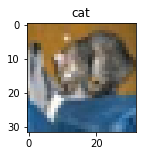

DescribeResult(nobs=3072, minmax=(0.05098042, 1.0), mean=0.42504343, variance=0.033470426, skewness=0.40827739238739014, kurtosis=-0.19684919801084266)


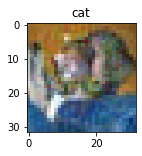

DescribeResult(nobs=3072, minmax=(0.013353288, 1.0), mean=0.42397618, variance=0.034899592, skewness=0.386104017496109, kurtosis=-0.25957739635918964)
Absolute Difference between original and changed image: 110.60932159423828
Squared Difference between original and changed image: 5.764379501342773



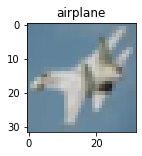

DescribeResult(nobs=3072, minmax=(0.09803921, 0.8392157), mean=0.5503574, variance=0.014919846, skewness=0.14759324491024017, kurtosis=-0.19514748729368936)


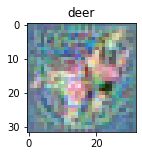

DescribeResult(nobs=3072, minmax=(0.026425987, 1.0), mean=0.55033535, variance=0.022242464, skewness=0.19119280576705933, kurtosis=0.163909201528456)
Absolute Difference between original and changed image: 247.12808227539062
Squared Difference between original and changed image: 28.779296875



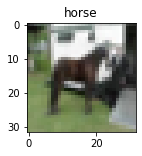

DescribeResult(nobs=3072, minmax=(0.027450979, 1.0), mean=0.4498264, variance=0.061991856, skewness=0.5384323000907898, kurtosis=-0.4859710768688572)


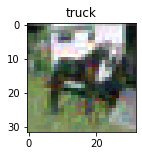

DescribeResult(nobs=3072, minmax=(0.0, 1.0), mean=0.45005307, variance=0.061469723, skewness=0.5232375264167786, kurtosis=-0.42518533776522105)
Absolute Difference between original and changed image: 116.17437744140625
Squared Difference between original and changed image: 6.90979528427124



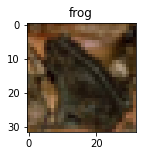

DescribeResult(nobs=3072, minmax=(0.0, 0.7372549), mean=0.23788808, variance=0.019016037, skewness=0.8943055272102356, kurtosis=0.2957676421992139)


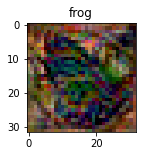

DescribeResult(nobs=3072, minmax=(0.0, 0.9078725), mean=0.2409957, variance=0.028062586, skewness=0.47436514496803284, kurtosis=-0.06388780681070783)
Absolute Difference between original and changed image: 311.04443359375
Squared Difference between original and changed image: 41.49827575683594



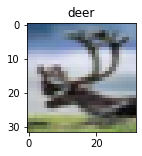

DescribeResult(nobs=3072, minmax=(0.0, 0.9647059), mean=0.52880925, variance=0.051635247, skewness=-0.11096050590276718, kurtosis=-1.0392622205458624)


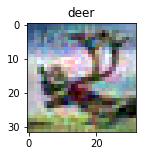

DescribeResult(nobs=3072, minmax=(0.0, 1.0), mean=0.5291543, variance=0.05680331, skewness=-0.13874532282352448, kurtosis=-0.8572570266498905)
Absolute Difference between original and changed image: 192.99046325683594
Squared Difference between original and changed image: 18.22953224182129



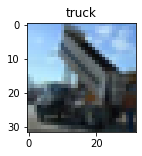

DescribeResult(nobs=3072, minmax=(0.015686303, 1.0), mean=0.44237518, variance=0.0826029, skewness=0.4665905237197876, kurtosis=-1.0385675701780042)


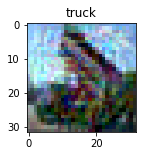

DescribeResult(nobs=3072, minmax=(0.0, 1.0), mean=0.4427431, variance=0.084268674, skewness=0.3531723618507385, kurtosis=-1.0302608803105175)
Absolute Difference between original and changed image: 223.30691528320312
Squared Difference between original and changed image: 24.01531410217285



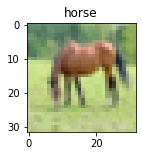

DescribeResult(nobs=3072, minmax=(0.015686303, 0.9372549), mean=0.56216043, variance=0.032985363, skewness=-0.13654246926307678, kurtosis=-0.6639576750466589)


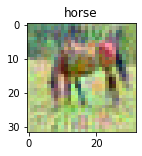

DescribeResult(nobs=3072, minmax=(0.0, 1.0), mean=0.5631173, variance=0.03511231, skewness=-0.1589919924736023, kurtosis=-0.44785856394700874)
Absolute Difference between original and changed image: 175.10250854492188
Squared Difference between original and changed image: 14.559755325317383



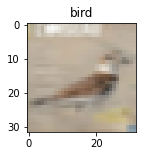

DescribeResult(nobs=3072, minmax=(0.18823528, 0.96862745), mean=0.6423139, variance=0.011977327, skewness=-0.8710635304450989, kurtosis=1.8474857294136093)


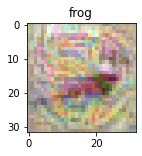

DescribeResult(nobs=3072, minmax=(0.085742235, 1.0), mean=0.64480525, variance=0.02149757, skewness=-0.4702911972999573, kurtosis=0.428432993332585)
Absolute Difference between original and changed image: 242.38839721679688
Squared Difference between original and changed image: 25.635578155517578



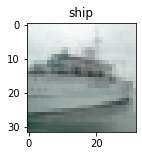

DescribeResult(nobs=3072, minmax=(0.14509803, 0.98039216), mean=0.63675576, variance=0.043443605, skewness=0.03995033726096153, kurtosis=-1.182072665465467)


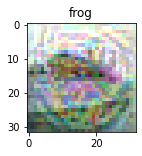

DescribeResult(nobs=3072, minmax=(0.024533957, 1.0), mean=0.6352724, variance=0.05194839, skewness=-0.07989277690649033, kurtosis=-0.9527375303977816)
Absolute Difference between original and changed image: 289.2828369140625
Squared Difference between original and changed image: 36.21548843383789



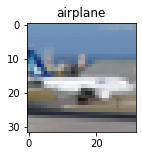

DescribeResult(nobs=3072, minmax=(0.054901958, 1.0), mean=0.53207976, variance=0.031514898, skewness=0.23152218759059906, kurtosis=0.19578882150240773)


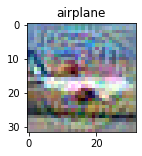

DescribeResult(nobs=3072, minmax=(0.0, 1.0), mean=0.53153014, variance=0.03705421, skewness=0.04449677839875221, kurtosis=0.09773387895498997)
Absolute Difference between original and changed image: 240.5840606689453
Squared Difference between original and changed image: 27.2030029296875



In [64]:
class ViewImage(nn.Module):

    def __init__(self, means, stds):
        super(ViewImage, self).__init__()
        self.means = means
        self.stds = stds

    def forward(self, x):
        denorm = transforms.Compose([
            transforms.Normalize(mean = [ 0., 0., 0. ],
                                 std = 1 / self.stds),
            transforms.Normalize(mean = -1 * self.means,
                                 std = [ 1., 1., 1. ]),
        ])
        return torch.clamp(denorm(x), 0., 1.)

from scipy import stats
adversarial_densenet.discriminator = ViewImage(means, stds)
test = ViewImage(means, stds)


for i in range(0,100, 10):

    plt.figure(figsize = (2,2))
    plt.title(test_dataset.classes[test_dataset[i][1]])
    denormed_img_1 = test.forward(test_dataset[i][0].unsqueeze(0))
    plt.imshow(transforms.ToPILImage()(denormed_img_1.squeeze(0)))
    plt.show()
    print(stats.describe(denormed_img_1.cpu().detach().flatten().numpy()))
    
    plt.figure(figsize = (2,2))
    adversarial_densenet.discriminator = densenet
    output = adversarial_densenet.forward(test_dataset[i][0].unsqueeze(0).to(device))
    plt.title(test_dataset.classes[output.argmax(dim=1)])

    
    adversarial_densenet.discriminator = ViewImage(means, stds)
    denormed_img_2 = adversarial_densenet.forward(
        test_dataset[i][0].unsqueeze(0).to(device))
    plt.imshow(transforms.ToPILImage()(denormed_img_2.squeeze(0)))
    plt.show()
    print(stats.describe(denormed_img_2.cpu().detach().flatten().numpy()))

    print("Absolute Difference between original and changed image:", 
          (denormed_img_1.to(device) - denormed_img_2).abs().sum().item())
    print("Squared Difference between original and changed image:", 
          (denormed_img_1.to(device) - denormed_img_2).square().sum().item())
    
    print()

Also experiment with training the image generator on the Densenet instead of the ConvNet

In [65]:
EPOCHS = 15
BATCH_SIZE = 128
LEARNING_RATE = 1e-5
L2_LAMBDA = 1e-2
L1_LAMBDA = 1e-3

adversarial_densenet = ImagePerturbation(densenet).to(device)

optimizer = optim.Adam(adversarial_densenet.perturbation.parameters(), 
                            lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

In [66]:
best_loss = -float('inf')

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(adversarial_densenet, train_loader, optimizer, 
                                  criterion, device)
    valid_loss, valid_acc = evaluate(adversarial_densenet, val_loader, criterion, 
                                     device)
        
    if valid_loss > best_loss:
        best_loss = valid_loss
        print("Worse loss, saving model. . .")
        torch.save(adversarial_densenet.state_dict(), 
                   os.path.join(MODELS, "adversarial-densenet.pt"))

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print("Epoch:", epoch+1, "| Epoch Time:", epoch_mins, "m ", epoch_secs,"s")
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

Worse loss, saving model. . .
Epoch: 1 | Epoch Time: 0 m  39 s
	Train Loss: 2.274 | Train Acc: 45.51%
	 Val. Loss: 3.071 |  Val. Acc: 33.96%
Worse loss, saving model. . .
Epoch: 2 | Epoch Time: 0 m  39 s
	Train Loss: 2.936 | Train Acc: 34.20%
	 Val. Loss: 3.689 |  Val. Acc: 22.00%
Worse loss, saving model. . .
Epoch: 3 | Epoch Time: 0 m  39 s
	Train Loss: 3.431 | Train Acc: 25.81%
	 Val. Loss: 4.108 |  Val. Acc: 17.27%
Worse loss, saving model. . .
Epoch: 4 | Epoch Time: 0 m  39 s
	Train Loss: 3.812 | Train Acc: 20.72%
	 Val. Loss: 4.450 |  Val. Acc: 14.62%
Worse loss, saving model. . .
Epoch: 5 | Epoch Time: 0 m  39 s
	Train Loss: 4.091 | Train Acc: 17.38%
	 Val. Loss: 4.674 |  Val. Acc: 12.33%
Worse loss, saving model. . .
Epoch: 6 | Epoch Time: 0 m  39 s
	Train Loss: 4.254 | Train Acc: 16.04%
	 Val. Loss: 4.781 |  Val. Acc: 11.48%
Worse loss, saving model. . .
Epoch: 7 | Epoch Time: 0 m  39 s
	Train Loss: 4.429 | Train Acc: 14.22%
	 Val. Loss: 4.885 |  Val. Acc: 11.10%
Worse loss, s

In [67]:
# Print results of training with Densenet instead

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

adversarial_densenet = ImagePerturbation(densenet)
adversarial_densenet.load_state_dict(
    torch.load(os.path.join(MODELS, "adversarial-densenet.pt")))
adversarial_densenet.eval()

# Adversarial convnet performance
print("ConvNet Performance with Adversarial Images:")
adversarial_densenet.discriminator = convnet
test_loss, test_acc = evaluate(adversarial_densenet, test_loader, criterion, device)
print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

# Replacing the model in adversarial convnet with densenet
print("DenseNet Performance with Adversarial Images:")
adversarial_densenet.discriminator = densenet
test_loss, test_acc = evaluate(adversarial_densenet, test_loader, criterion, device)
print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

# Replacing the model in adversarial densenet with resnet
print("ResNet Performance with Adversarial Images:")
adversarial_densenet.discriminator = resnet50
test_loss, test_acc = evaluate(adversarial_densenet, test_loader, criterion, device)
print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

ConvNet Performance with Adversarial Images:
	 Test Loss: 2.143 |  Test Acc: 42.32%
DenseNet Performance with Adversarial Images:
	 Test Loss: 2.594 |  Test Acc: 40.67%
ResNet Performance with Adversarial Images:
	 Test Loss: 6.317 |  Test Acc: 20.14%


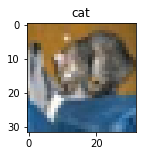

DescribeResult(nobs=3072, minmax=(0.05098042, 1.0), mean=0.42504343, variance=0.033470426, skewness=0.40827739238739014, kurtosis=-0.19684919801084266)


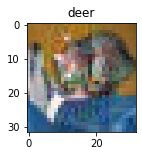

DescribeResult(nobs=3072, minmax=(0.03962645, 1.0), mean=0.42529526, variance=0.035168696, skewness=0.37557241320610046, kurtosis=-0.27682477202036715)
Absolute Difference between original and changed image: 96.639404296875
Squared Difference between original and changed image: 5.560616970062256



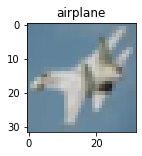

DescribeResult(nobs=3072, minmax=(0.09803921, 0.8392157), mean=0.5503574, variance=0.014919846, skewness=0.14759324491024017, kurtosis=-0.19514748729368936)


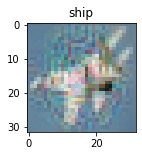

DescribeResult(nobs=3072, minmax=(0.029560417, 0.9469752), mean=0.5493036, variance=0.017529871, skewness=0.21031978726387024, kurtosis=0.21741116291574603)
Absolute Difference between original and changed image: 112.91622924804688
Squared Difference between original and changed image: 8.194378852844238



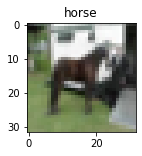

DescribeResult(nobs=3072, minmax=(0.027450979, 1.0), mean=0.4498264, variance=0.061991856, skewness=0.5384323000907898, kurtosis=-0.4859710768688572)


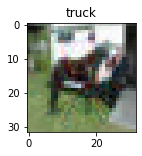

DescribeResult(nobs=3072, minmax=(0.0, 1.0), mean=0.45033303, variance=0.06305087, skewness=0.49753889441490173, kurtosis=-0.47056571369764333)
Absolute Difference between original and changed image: 78.93455505371094
Squared Difference between original and changed image: 4.175534725189209



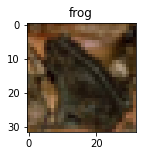

DescribeResult(nobs=3072, minmax=(0.0, 0.7372549), mean=0.23788808, variance=0.019016037, skewness=0.8943055272102356, kurtosis=0.2957676421992139)


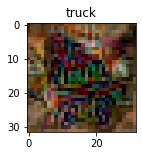

DescribeResult(nobs=3072, minmax=(0.0, 0.82655966), mean=0.24167216, variance=0.02646594, skewness=0.45719102025032043, kurtosis=-0.28897665235929937)
Absolute Difference between original and changed image: 220.399169921875
Squared Difference between original and changed image: 25.886024475097656



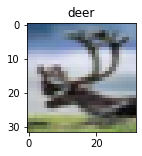

DescribeResult(nobs=3072, minmax=(0.0, 0.9647059), mean=0.52880925, variance=0.051635247, skewness=-0.11096050590276718, kurtosis=-1.0392622205458624)


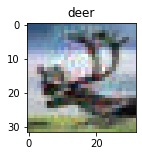

DescribeResult(nobs=3072, minmax=(0.0, 1.0), mean=0.5283461, variance=0.05334165, skewness=-0.10900402069091797, kurtosis=-0.9412354161739525)
Absolute Difference between original and changed image: 95.91963195800781
Squared Difference between original and changed image: 6.070131301879883



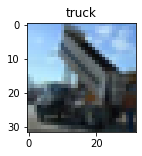

DescribeResult(nobs=3072, minmax=(0.015686303, 1.0), mean=0.44237518, variance=0.0826029, skewness=0.4665905237197876, kurtosis=-1.0385675701780042)


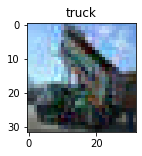

DescribeResult(nobs=3072, minmax=(0.0, 1.0), mean=0.4426527, variance=0.08403701, skewness=0.42640888690948486, kurtosis=-1.0389693276177019)
Absolute Difference between original and changed image: 102.57324981689453
Squared Difference between original and changed image: 7.02726936340332



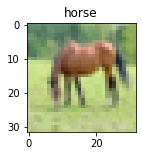

DescribeResult(nobs=3072, minmax=(0.015686303, 0.9372549), mean=0.56216043, variance=0.032985363, skewness=-0.13654246926307678, kurtosis=-0.6639576750466589)


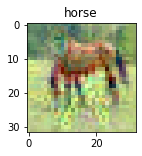

DescribeResult(nobs=3072, minmax=(0.0, 1.0), mean=0.5619963, variance=0.03612715, skewness=-0.16502641141414642, kurtosis=-0.3844185704546135)
Absolute Difference between original and changed image: 148.24713134765625
Squared Difference between original and changed image: 12.705934524536133



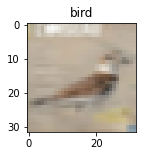

DescribeResult(nobs=3072, minmax=(0.18823528, 0.96862745), mean=0.6423139, variance=0.011977327, skewness=-0.8710635304450989, kurtosis=1.8474857294136093)


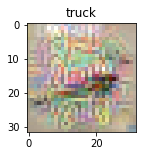

DescribeResult(nobs=3072, minmax=(0.0335159, 1.0), mean=0.6418105, variance=0.019872487, skewness=-0.5273548364639282, kurtosis=0.8956526343714253)
Absolute Difference between original and changed image: 213.7157745361328
Squared Difference between original and changed image: 24.267213821411133



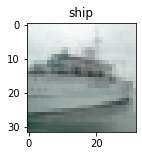

DescribeResult(nobs=3072, minmax=(0.14509803, 0.98039216), mean=0.63675576, variance=0.043443605, skewness=0.03995033726096153, kurtosis=-1.182072665465467)


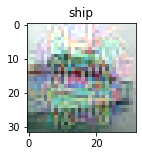

DescribeResult(nobs=3072, minmax=(0.047080874, 1.0), mean=0.63450694, variance=0.050570898, skewness=-0.09515319019556046, kurtosis=-1.0635918853483268)
Absolute Difference between original and changed image: 215.80712890625
Squared Difference between original and changed image: 24.988534927368164



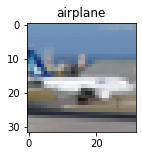

DescribeResult(nobs=3072, minmax=(0.054901958, 1.0), mean=0.53207976, variance=0.031514898, skewness=0.23152218759059906, kurtosis=0.19578882150240773)


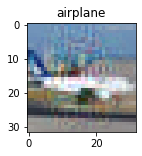

DescribeResult(nobs=3072, minmax=(0.008990228, 1.0), mean=0.53097147, variance=0.032957166, skewness=0.17529664933681488, kurtosis=0.16941212346150136)
Absolute Difference between original and changed image: 95.45044708251953
Squared Difference between original and changed image: 5.8540568351745605



In [68]:
# Plot example images generated by the Adversarial images trained with DenseNet
adversarial_densenet.discriminator = ViewImage(means, stds)
test = ViewImage(means, stds)

for i in range(0,100, 10):

    plt.figure(figsize = (2,2))
    plt.title(test_dataset.classes[test_dataset[i][1]])
    denormed_img_1 = test.forward(test_dataset[i][0].unsqueeze(0))
    plt.imshow(transforms.ToPILImage()(denormed_img_1.squeeze(0)))
    plt.show()
    print(stats.describe(denormed_img_1.cpu().detach().flatten().numpy()))
    
    plt.figure(figsize = (2,2))
    adversarial_densenet.discriminator = densenet
    output = adversarial_densenet.forward(test_dataset[i][0].unsqueeze(0).to(device))
    plt.title(test_dataset.classes[output.argmax(dim=1)])

    
    adversarial_densenet.discriminator = ViewImage(means, stds)
    denormed_img_2 = adversarial_densenet.forward(
        test_dataset[i][0].unsqueeze(0).to(device))
    plt.imshow(transforms.ToPILImage()(denormed_img_2.squeeze(0)))
    plt.show()
    print(stats.describe(denormed_img_2.cpu().detach().flatten().numpy()))

    print("Absolute Difference between original and changed image:", 
          (denormed_img_1.to(device) - denormed_img_2).abs().sum().item())
    print("Squared Difference between original and changed image:", 
          (denormed_img_1.to(device) - denormed_img_2).square().sum().item())
    
    print()

(5.371041226387024, 0.18174402564764022)
torch.Size([512, 3, 32, 32]) torch.Size([512])
torch.Size([512, 10])
torch.Size([512])
(512,) (512,)
[[17  2  8 10  1 14  2  2  1  0]
 [12  4  9 10  0  0  5  1  0  0]
 [ 7  5 22  6  0  7  1  0  0  3]
 [ 5 10 11 16  0  4  2  0  0  1]
 [ 6  6 15 10  1  4  1  0  0  1]
 [ 5  4 13 18  0 10  0  0  0  0]
 [ 5 17  8 14  0  2  9  0  0  1]
 [ 9  1 16 13  0  5  0  4  0  0]
 [ 8  0 13 13  1 15  3  1  3  0]
 [10  1  8 30  0  5  3  0  0  2]]


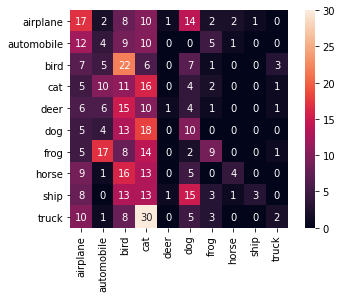

In [69]:
# Plot a confusion matrix for 
# TRAINING SET SIZE = 20000
# EPOCHS = 15
# BATCH_SIZE = 128
# LEARNING_RATE = 1e-5
# L2_LAMBDA = 1e-2
# L1_LAMBDA = 1e-3
from sklearn.metrics import confusion_matrix

adversarial_images = ImagePerturbation(convnet)
adversarial_images.load_state_dict(
    torch.load(os.path.join(MODELS, "adversarial.pt")))
adversarial_images.eval()
adversarial_images.to(device)

test_loader = dataloader.DataLoader(dataset=test_dataset, batch_size=512)

print(evaluate(adversarial_images, test_loader, criterion, device))

X, y = next(iter(test_loader))
print(X.shape, y.shape)
y_pred = adversarial_images(X.to(device))
print(y_pred.shape)
y_pred = y_pred.argmax(dim=1)
print(y_pred.shape)
y = y.numpy()
y_pred = y_pred.cpu().detach().numpy()
print(y.shape, y_pred.shape)

confusions = confusion_matrix(y, y_pred)
print(confusions)

import pandas as pd

confusion_df = pd.DataFrame(data=confusions, index=test_dataset.classes, 
                            columns=test_dataset.classes)

import seaborn as sns

sns.heatmap(data=confusion_df, annot=True, cbar=True, square=True, )

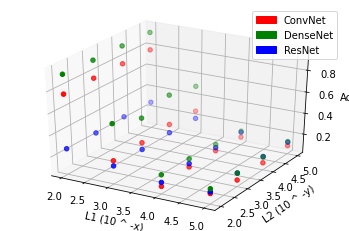

In [71]:
# Generating the Scatter3d plot shown in the paper

# from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig = plt.figure()
ax = plt.axes(projection='3d')

x = [5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2]
y = [5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2]
conv_z = [0.1013, 0.0904, 0.0855, 0.1238, 0.0984, 0.1169, 0.1176, 0.0946, 0.2690, 0.2846, 0.2589, 0.2429, 0.7780, 0.7767, 0.7765, 0.7688]
dense_z = [0.1418, 0.1483, 0.1514, 0.1677, 0.1577, 0.1773, 0.1953, 0.2037, 0.5089, 0.5630, 0.4900, 0.5853, 0.9400, 0.9400, 0.9389, 0.9451]
res_z = [0.1364, 0.1507, 0.1517, 0.1391, 0.1469, 0.1479, 0.1499, 0.1321, 0.1979, 0.2042, 0.1946, 0.1945, 0.2744, 0.2744, 0.2657, 0.2665]
ax.set_xlabel('L1 (10 ^ -x)')
ax.set_ylabel('L2 (10 ^ -y)')
ax.set_zlabel('Acc')
ax.scatter3D(x, y, conv_z, c='r')
ax.scatter3D(x, y, dense_z, c='g')
ax.scatter3D(x, y, res_z, c='b')
conv_patch = mpatches.Patch(color='r', label='ConvNet')
dense_patch = mpatches.Patch(color='g', label='DenseNet')
res_patch = mpatches.Patch(color='b', label='ResNet')
ax.legend(loc='upper right', handles=[conv_patch, dense_patch, res_patch])
plt.show()